# Modal organization in Chinese Folk Songs - Milestone 3
-----------
## Research questions
-------
In the ninth chapter of his book *Sweet Anticipation*[[1]](https://mitpress.mit.edu/books/sweet-anticipation), David Huron studies the concept of tonality, which he describes as "a system for interpreting pitches [...] through their relationship to a reference pitch, dubbed the tonic". For this purpose, Huron statistically analyses the scale degrees of a corpus of Germanic Folk Songs by computing their distributions, transitions, or entropy. While this study makes many interesting findings of Western music, it is concluded by saying that hardly any such research had been made for non-Western music.

Therefore this project endeavours to provide a similar analysis for a corpus of Chinese Folk Songs (hereafter CFS). It will strive to find similarities and differences in the CFS across regions based on their *modal organization*, which we define as the structure of a piece around its central pitch (i.e. the analysis of scale degrees). 

CFS stems from an oral tradition of people casually singing during their daily life. Therefore, CFS presents diverse stylistic characteristics as their composition is closely related to the people's lifestyle and is influenced by geographical conditions, customs and habits. For instance, in the Northwest Plateau that throve with agriculture, folk songs were usually sung in the fields during their work. In contrast, in the Jiangsu and Zhejiang Plains, where culture was more developed and where life was more prosperous, singing folk songs became entertainment and a means to socialize. This tradition gave birth to the Xiao Diao: folk songs with a soft and gentle style. In the Northeast Plain, where people are known to be very open and outgoing, a more dynamic style accompanied by a dance called Yangko developed. As a final example, in the Southeast of Guangxi and parts of Hainan, sea shanties were prominent amongst folk songs, as fishermen used to be a dominant social class in the area [[2]](https://baike.baidu.com/item/%E4%B8%AD%E5%9B%BD%E6%B0%91%E6%AD%8C).

Therefore, given the vast country, China is and having a wide variety of lifestyles, we hypothesize that major differences will be found between regions due to the high diversity of cultures inside a single country.

## Assumptions
-------

1. For this project, we will assume that the pieces of our corpus of CFS are composed in the pentatonic scale.
2. As scale degrees will be analyzed, the "tonic" of each CFS must be determined. For this project, the tonic will be understood as a "central pitch", i.e. the most recurring pitch on high beats. Thus, in the dataset below, the tonic has been computed as the pitch with the highest combination of duration and beat strength, while also giving a bonus to the last pitch of the piece. The scale degrees are then obtained by translating the pieces to C relatively to their tonic.

## Data
-------

We use approximately 2250 CFS that are available in the Essen Folksong Database[[3]](http://www.esac-data.org/) that contains more than 20,000 scores of folksongs from various regions. We divide China into 9 regions based on the provinces as shown in the figure below and each song is assigned into one of the 9 regions based on the province information it is annotated with. The division is based on the description of the geographical distribution of CFS on the Chinese Encyclopedia website[[2]](https://baike.baidu.com/item/%E4%B8%AD%E5%9B%BD%E6%B0%91%E6%AD%8C). In this process, we ignore those songs whose province information is absent along with those songs that do have empty song data. Lastly, we observed that there are only 5 songs from the Zang region and it is too little data to make any significant claims, we ignore the pieces from the Zang region in this analysis.

<img src="https://raw.githubusercontent.com/ravinitheshreddy/Digital-Musicology-Project/main/img/map.jpg" alt="map" width="450"/>


## Methods and Results
---------

To investigate the similarities and differences between the CFS we first look at the scale degree distributions of each region, followed by scale degree and interval transitions. These methods would help us understand the organisation and movement of the notes in the music belonging to the given region. Later, we look at the scale degree flexibility and the stable notes of the region to unearth the stability in movement between notes.

### Imports

In [1]:
from music21 import *
import glob
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
from collections import Counter, OrderedDict
import networkx as nx
import math
from fractions import Fraction
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from seaborn.algorithms import bootstrap

### Data loading
The following helper function converts the string representation of a Python list of floats, to an actual list of floats

In [2]:
def string_to_float_list(string_list):
    try:
        return [float(x) for x in string_list.replace("[", "").replace("]", "").replace(" ","").split(",")]
    except:
        return None

The dataset that we created in the previous Milestone is loaded using `pandas` and the beat strengths and durations column are converted using the previous helper function.

In [3]:
CFS_full = pd.read_csv("./data/dataframes/cfs_full.csv", converters={'pitches': eval,'pitchclasses': eval, 'intervals':eval, 'pitches_transposed': eval,'pitchclasses_transposed': eval,'top5_after_transpose': eval})
CFS_full.beat_strengths = CFS_full.beat_strengths.apply(string_to_float_list)
CFS_full.durations = CFS_full.durations.apply(string_to_float_list)
CFS_full = CFS_full[~ ((CFS_full.pitches.isna()) | (CFS_full.durations.isna()) | (CFS_full.beat_strengths.isna()) | (CFS_full["geo_division"] == "Zang"))]

### Helper lists and dictionaries
The following lists and dictionaries are simple helpers for the following visualization to have the name of all regions, pitch classes, and intervals at disposal.

In [4]:
geo_divisions = ["Northwest", "Central", "Southwest", "Northeast", "Jiangzhe", "Southeast", "Neimeng", "Jiang"]
pitch_classes_list = ['A', 'A#', 'A-', 'B', 'B#', 'B-', 'C', 'C#', 'C-', 'D', 'D#', 'D-', 'E', 'E#', 'E-', 'F', 'F#', 'G', 'G#', 'G-']
music_interval_list = ['A1','A2','A3','A4','A5','A6','A7','P1','P4','P5','P8','m2','M2','m3','M3','m6','M6','m7','M7','d1','d2','d3','d4','d5','d6','d7','d8']

pitchclasses_defcount = {pc:0 for pc in pitch_classes_list}
pitchclasses_transitions_defcount = {pc1:{pc2:0 for pc2 in pitch_classes_list} for pc1 in pitch_classes_list}
intervals_defcount = {pc:0 for pc in music_interval_list}

The following dictionaries contain the concatenated information for each region. For example, `region_pitch_stat["Northwest"]` contains a list of all pitches used in the Northwest region.

In [5]:
region_scaledegrees_stat = {}
region_intervals_stat = {}
region_durations_stat = {}
region_beat_strengths_stat = {}

for gloc in geo_divisions: 
    region_df = CFS_full[CFS_full["geo_division"]==gloc]
    region_scaledegrees_stat[gloc] = sum(region_df["pitchclasses_transposed"].tolist(), [])
    region_intervals_stat[gloc] = sum(region_df["intervals"].tolist(), [])
    region_durations_stat[gloc] = sum(region_df["durations"].tolist(), [])
    region_beat_strengths_stat[gloc] = sum(region_df["beat_strengths"].tolist(), [])

In [232]:
def bootstrap_notes_95_CI_count(data, notes, values, nbr_draws):
    counts = np.zeros((nbr_draws, len(notes)))
    data = np.array(data)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices]
        counter = Counter(data_tmp)
        for i in range(len(notes)):
            try:
                counts[n][i] = dict(counter)[notes[i]] / len(data)
            except:
                counts[n][i] = 0
    return [[abs(np.nanpercentile(counts.transpose()[i], 2.5) - values[i]),np.nanpercentile(counts.transpose()[i], 97.5) - values[i]] for i in range(len(counts.transpose()))]

In [244]:
def bootstrap_notes_95_CI_met(data, notes, durations, beat_strengths, values, nbr_draws):
    counts = np.zeros((nbr_draws, len(notes)))
    data = np.array(data)
    durations = np.array(durations)
    beat_strengths = np.array(beat_strengths)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices]
        durations_tmp = durations[indices]
        beat_strengths_tmp = beat_strengths[indices]
        
        counter = {}
        for i in range(len(data_tmp)):
            if math.isnan(beat_strengths_tmp[i]) or math.isnan(durations_tmp[i]):
                continue
            if not data_tmp[i] in counter.keys():
                counter[data_tmp[i]] = durations_tmp[i]*beat_strengths_tmp[i]
            else:
                counter[data_tmp[i]] +=  durations_tmp[i]*beat_strengths_tmp[i]
        for i in range(len(notes)):
            try:
                counts[n][i] = dict(counter)[notes[i]] / len(data)
            except:
                counts[n][i] = 0
    return [[abs(np.nanpercentile(counts.transpose()[i], 2.5) - values[i]),np.nanpercentile(counts.transpose()[i], 97.5) - values[i]] for i in range(len(counts.transpose()))]

The function below is a generic function that allows plotting a sorted histogram of the statistic given as a parameter. 

In [245]:
def plot_region_stat_counts(stat, defcount=None, figsize=(20,12), nrows=2, ncols=4, log_y=False, sort=True, title="{}"):
    plt.rcParams["figure.figsize"] = figsize
    region_counts = {}
    fig, axarr = plt.subplots(nrows, ncols, constrained_layout=True)

    for gloc,ax in zip(stat, axarr.flat):
        counter = Counter(stat[gloc])
        fractions = {i:counter[i] / len(stat[gloc]) for i in counter}
        if defcount is not None:
            fractions = {**defcount, **fractions}
        region_counts[gloc] = sorted(fractions.items(), key=lambda pair: -pair[1]) if sort else fractions.items()
        x, y = zip(*region_counts[gloc])
        x = list(x)
        y = list(y)
        ci = bootstrap_notes_95_CI_count(stat[gloc], x, y, 1000)
        ci = np.array(ci).transpose()
        ax.bar(x, y, color='black', yerr=ci, ecolor="red", capsize=2)
        if log_y:
            ax.set_yscale('log')
        ax.set_title(title.format(gloc), fontdict={'fontsize': 16})

### Scale degrees distributions

#### Frequencies with metrical structure

A simple count of scale degrees does not account for the metrical structure. Indeed, the scale degree of the first note of the piece does not have the same importance as the second one. Therefore, a weight corresponding to the product of the duration and beat strength is assigned to each scale degree. The following helper function plots histograms of the given statistics using this weighted method.

In [248]:
def plot_region_stat_met(stat, defcount=None, figsize=(20,8), nrows=2, ncols=4, log_y=False, sort=True, title="{}"):
    plt.rcParams["figure.figsize"] = figsize
    region_counts = {}
    fig, axarr = plt.subplots(nrows, ncols, constrained_layout=True)

    for gloc ,ax in zip(stat, axarr.flat):

        counter = {}
        for i in range(len(stat[gloc])):
            if math.isnan(region_beat_strengths_stat[gloc][i]) or math.isnan(region_durations_stat[gloc][i]):
                continue
            if not stat[gloc][i] in counter.keys():
                counter[stat[gloc][i]] = region_durations_stat[gloc][i]*region_beat_strengths_stat[gloc][i]
            else:
                counter[stat[gloc][i]] +=  region_durations_stat[gloc][i]*region_beat_strengths_stat[gloc][i]

        fractions = {i:counter[i] / len(stat[gloc]) for i in counter}
        if defcount is not None:
            fractions = {**defcount, **fractions}
        region_counts[gloc] = sorted(fractions.items(), key=lambda pair: -pair[1]) if sort else fractions.items()
        x, y = zip(*region_counts[gloc])
        ci = bootstrap_notes_95_CI_met(stat[gloc], x, region_durations_stat[gloc], region_beat_strengths_stat[gloc], y, 1000)
        ci = np.array(ci).transpose()
        ax.bar(x, y, color='black', yerr=ci, ecolor="red", capsize=2)
        if log_y:
            ax.set_yscale('log')
        ax.set_title(title.format(gloc), fontdict={'fontsize': 16})

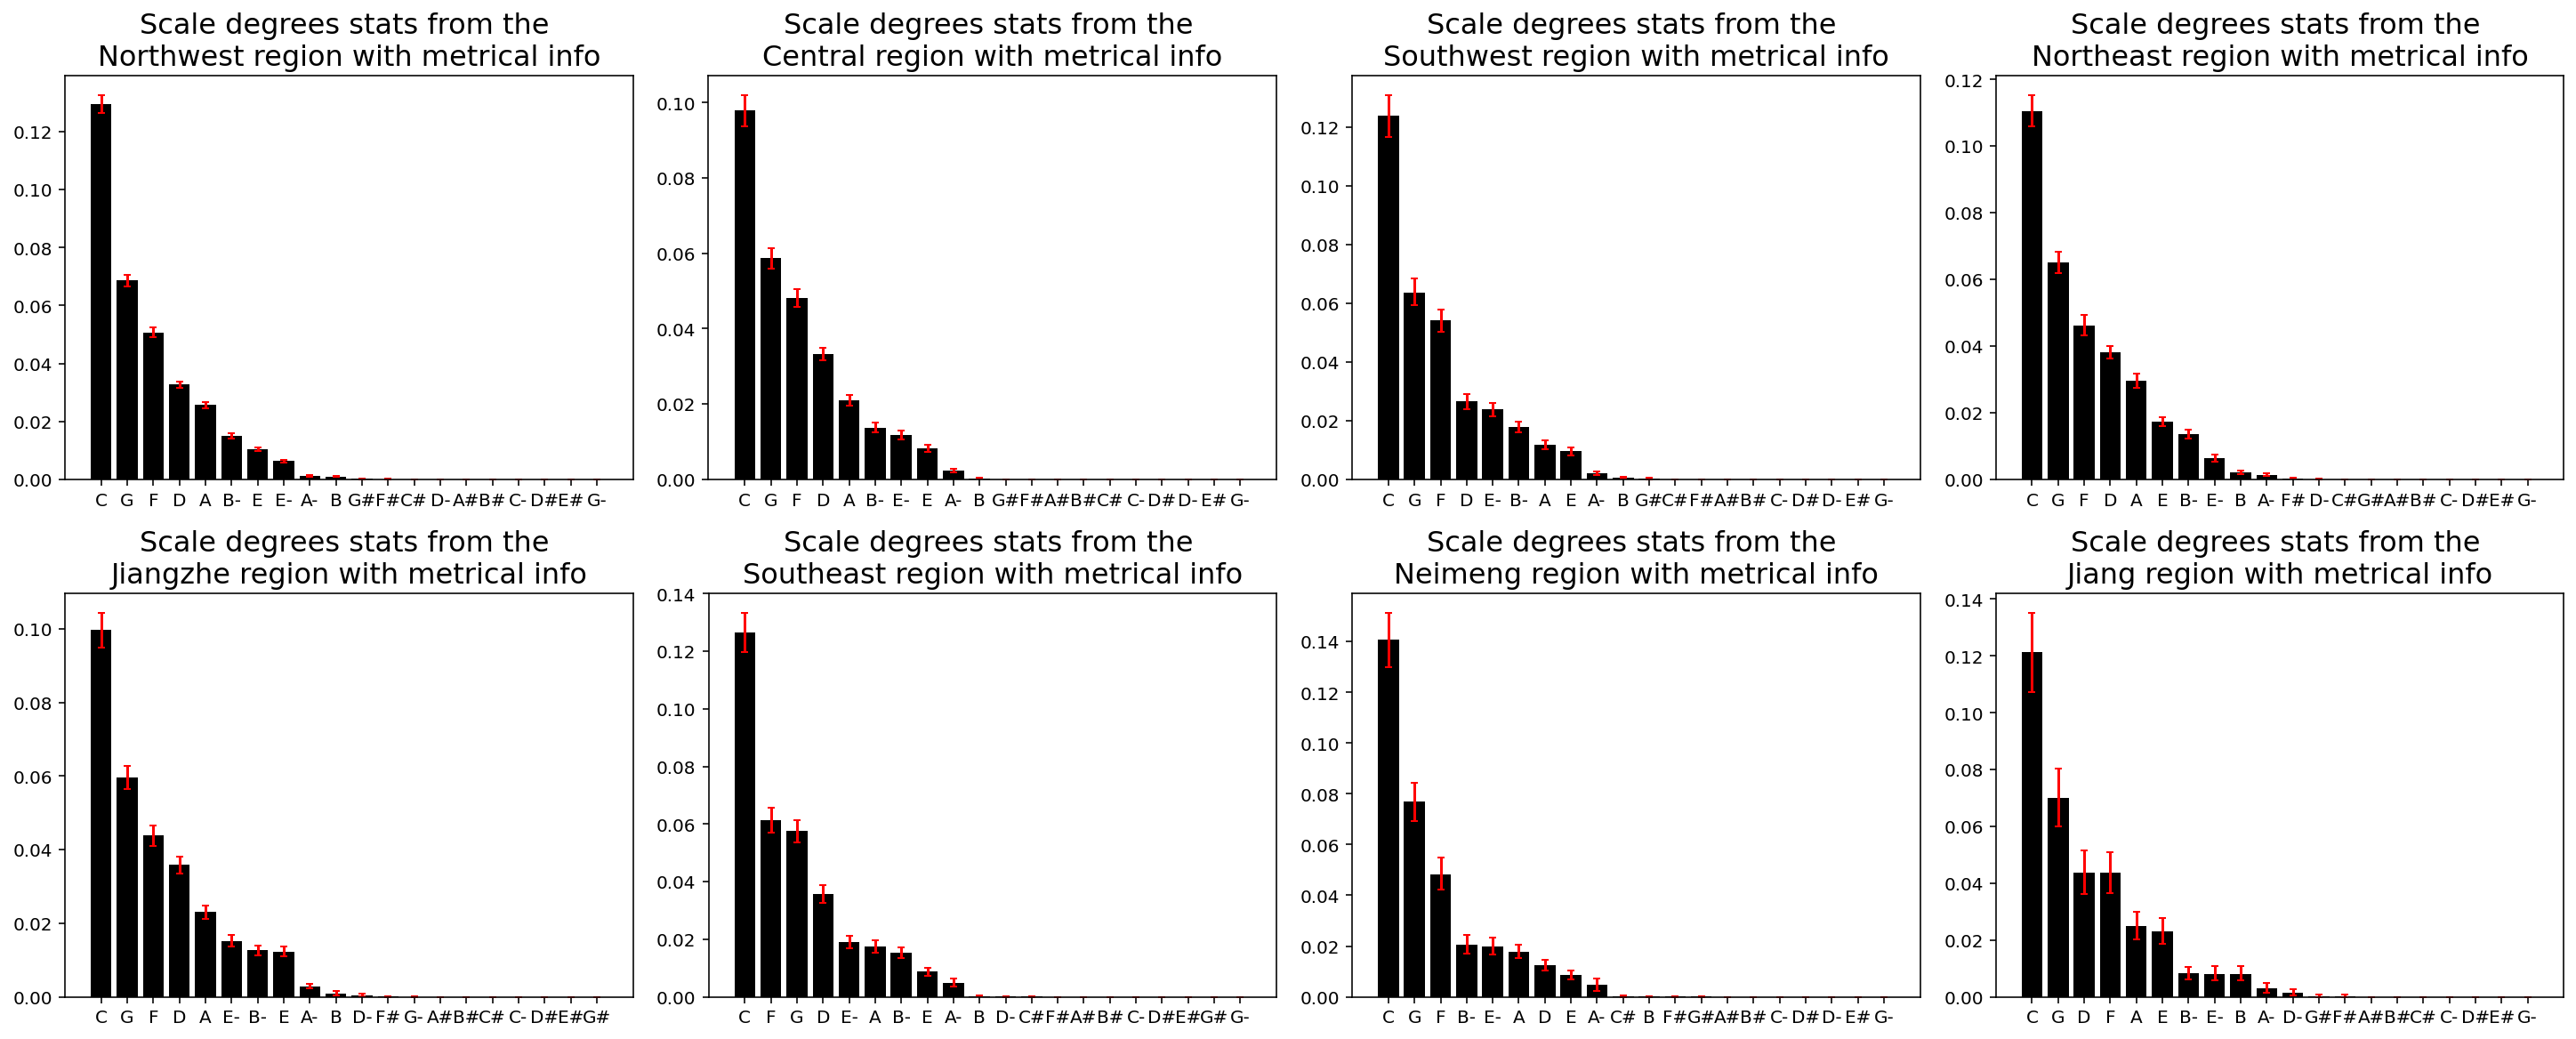

In [249]:
plot_region_stat_met(region_scaledegrees_stat, pitchclasses_defcount, title="Scale degrees stats from the \n{} region with metrical info")

As the scale degrees have been computed by translating the pieces to C relatively to their tonic, in the plots below, C is to be understood as the tonic, G as the dominant, F as the subdominant, etc... The results of this analysis show a tonal hierarchy very similar to one computed by Huron on Germanic Folk Songs (*Sweet Anticipation*, Huron 2006). It is not surprising to find the tonic as the most frequent scale degree since it is part of how it was defined. However, as the dominant, subdominant, and second are the next most frequent scale degrees in all regions, this analysis shows the great similarity between regions and thus goes against our initial hypothesis.

#### Statistical Comparision

To compare the distributions statistically, we compute the Spearman Rank correlation between the distributions to obtain the similarity/ dissimilarity between the regions. 

In [250]:
def plot_statistical_comparision(stat, defcount, vmin, figsize=(10,8), title="{}"):
    plt.rcParams["figure.figsize"] = figsize
    region_counts = {}

    for gloc in stat:

        counter = {}
        for i in range(len(stat[gloc])):
            if math.isnan(region_beat_strengths_stat[gloc][i]) or math.isnan(region_durations_stat[gloc][i]):
                continue
            if not stat[gloc][i] in counter.keys():
                counter[stat[gloc][i]] = region_durations_stat[gloc][i]*region_beat_strengths_stat[gloc][i]
            else:
                counter[stat[gloc][i]] +=  region_durations_stat[gloc][i]*region_beat_strengths_stat[gloc][i]

        fractions = {i:counter[i] / len(stat[gloc]) for i in counter}
        fractions = {**defcount, **fractions}
        region_counts[gloc] = list(fractions.items())
    
    sorted_region_property_distribution = {region:sorted(dist, key=lambda x:x[0]) for region, dist in region_counts.items()}
    sorted_region_property_values = {region: [val for key,val in dist] for  region, dist in sorted_region_property_distribution.items()}
    property_df = pd.DataFrame.from_dict(sorted_region_property_values)


    colormap = sns.color_palette("Blues", as_cmap=True)
    spearman_corrdf = property_df.corr(method="spearman")

    ax = sns.heatmap(spearman_corrdf, cmap= colormap, square=True, linecolor='black', linewidths=0.1, vmin=vmin, annot=True)
    ax.set_title("Spearman correlation of {}".format(title))

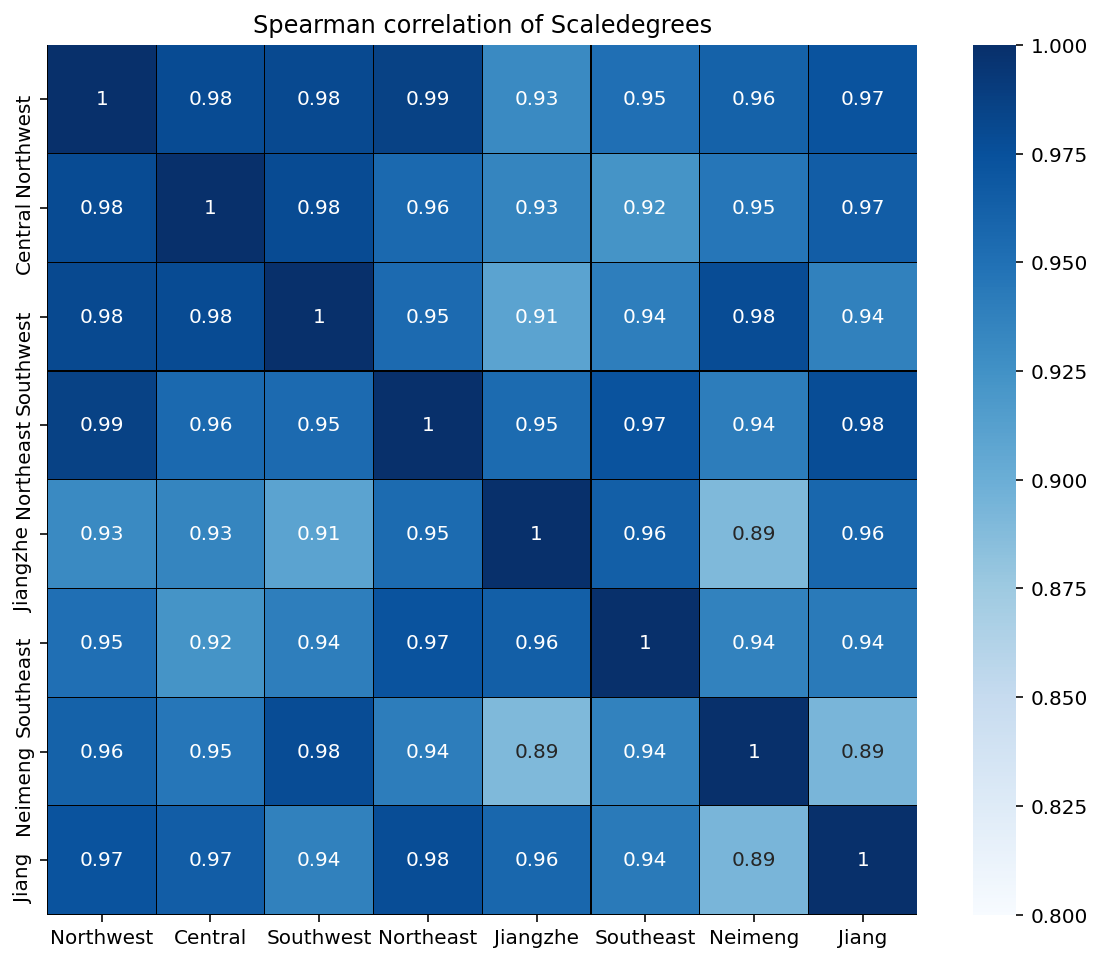

In [251]:
plot_statistical_comparision(region_scaledegrees_stat, pitchclasses_defcount, vmin=0.8, title="Scaledegrees")

The correlation suggests to the scale degree usage is similar across the regions. A lower similarity can be found among Jiangzhe and Neimeng, and Neimeng and Jiang.

### Scale degrees transitions

While the frequencies of scale degrees only show regional similarities, the transitions between them may reveal differences. Indeed, such an analysis may reveal for example that in one region the tonic most often translates to the dominant, while in another region it most often goes to the second.

To do so, we first iterate overall pieces of all regions to count the number of transitions in each region. A dictionary is created to store this count, for which the keys correspond to the regions' names and the values are nested dictionaries. These nested dictionaries have the starting scale degrees as keys and their values are dictionaries containing the landing scale degrees as keys and the count of such transition as values.

As an example is more telling than a lengthy explanation, here is an example of the start of this dictionary containing the number of transitions from C in the Northwest region:
```python
{'Northwest': 
    {'C': 
       {'G': 1572,
       'C': 2904,
       'F': 1581,
       'B-': 1507,
       'E-': 376,
       'D': 2469,
       'A': 1909,
       'G#': 2,
       'E': 329,
       'B': 119,
       'A-': 21,
       'D-': 5},
     ...
    }
}
```

In [252]:
pitchclass_transition_absolute = {geo_region: {} for geo_region in geo_divisions}
for index, row in CFS_full.iterrows():
    prev_pitchclass = None
    region = row["geo_division"]
    for pitchclass in row["pitchclasses_transposed"]:
        if prev_pitchclass is not None:
            if prev_pitchclass not in pitchclass_transition_absolute[region]:
                pitchclass_transition_absolute[region][prev_pitchclass] = {}
            if pitchclass not in  pitchclass_transition_absolute[region][prev_pitchclass]:
                pitchclass_transition_absolute[region][prev_pitchclass][pitchclass] = 1
            else:
                pitchclass_transition_absolute[region][prev_pitchclass][pitchclass] += 1
        prev_pitchclass = pitchclass

These transitions can then be plotted as heatmaps. To create them, we first convert the transition counts from a dictionary to a `DataFrame` and use it to plot the heatmap.

In [9]:
def sort_dict(item):
    # function to sort a nested dictionary based on key
    # credits: https://gist.github.com/gyli/f60f0374defc383aa098d44cfbd318eb
    return {k: sort_dict(v) if isinstance(v, dict) else v for k, v in sorted(item.items())}

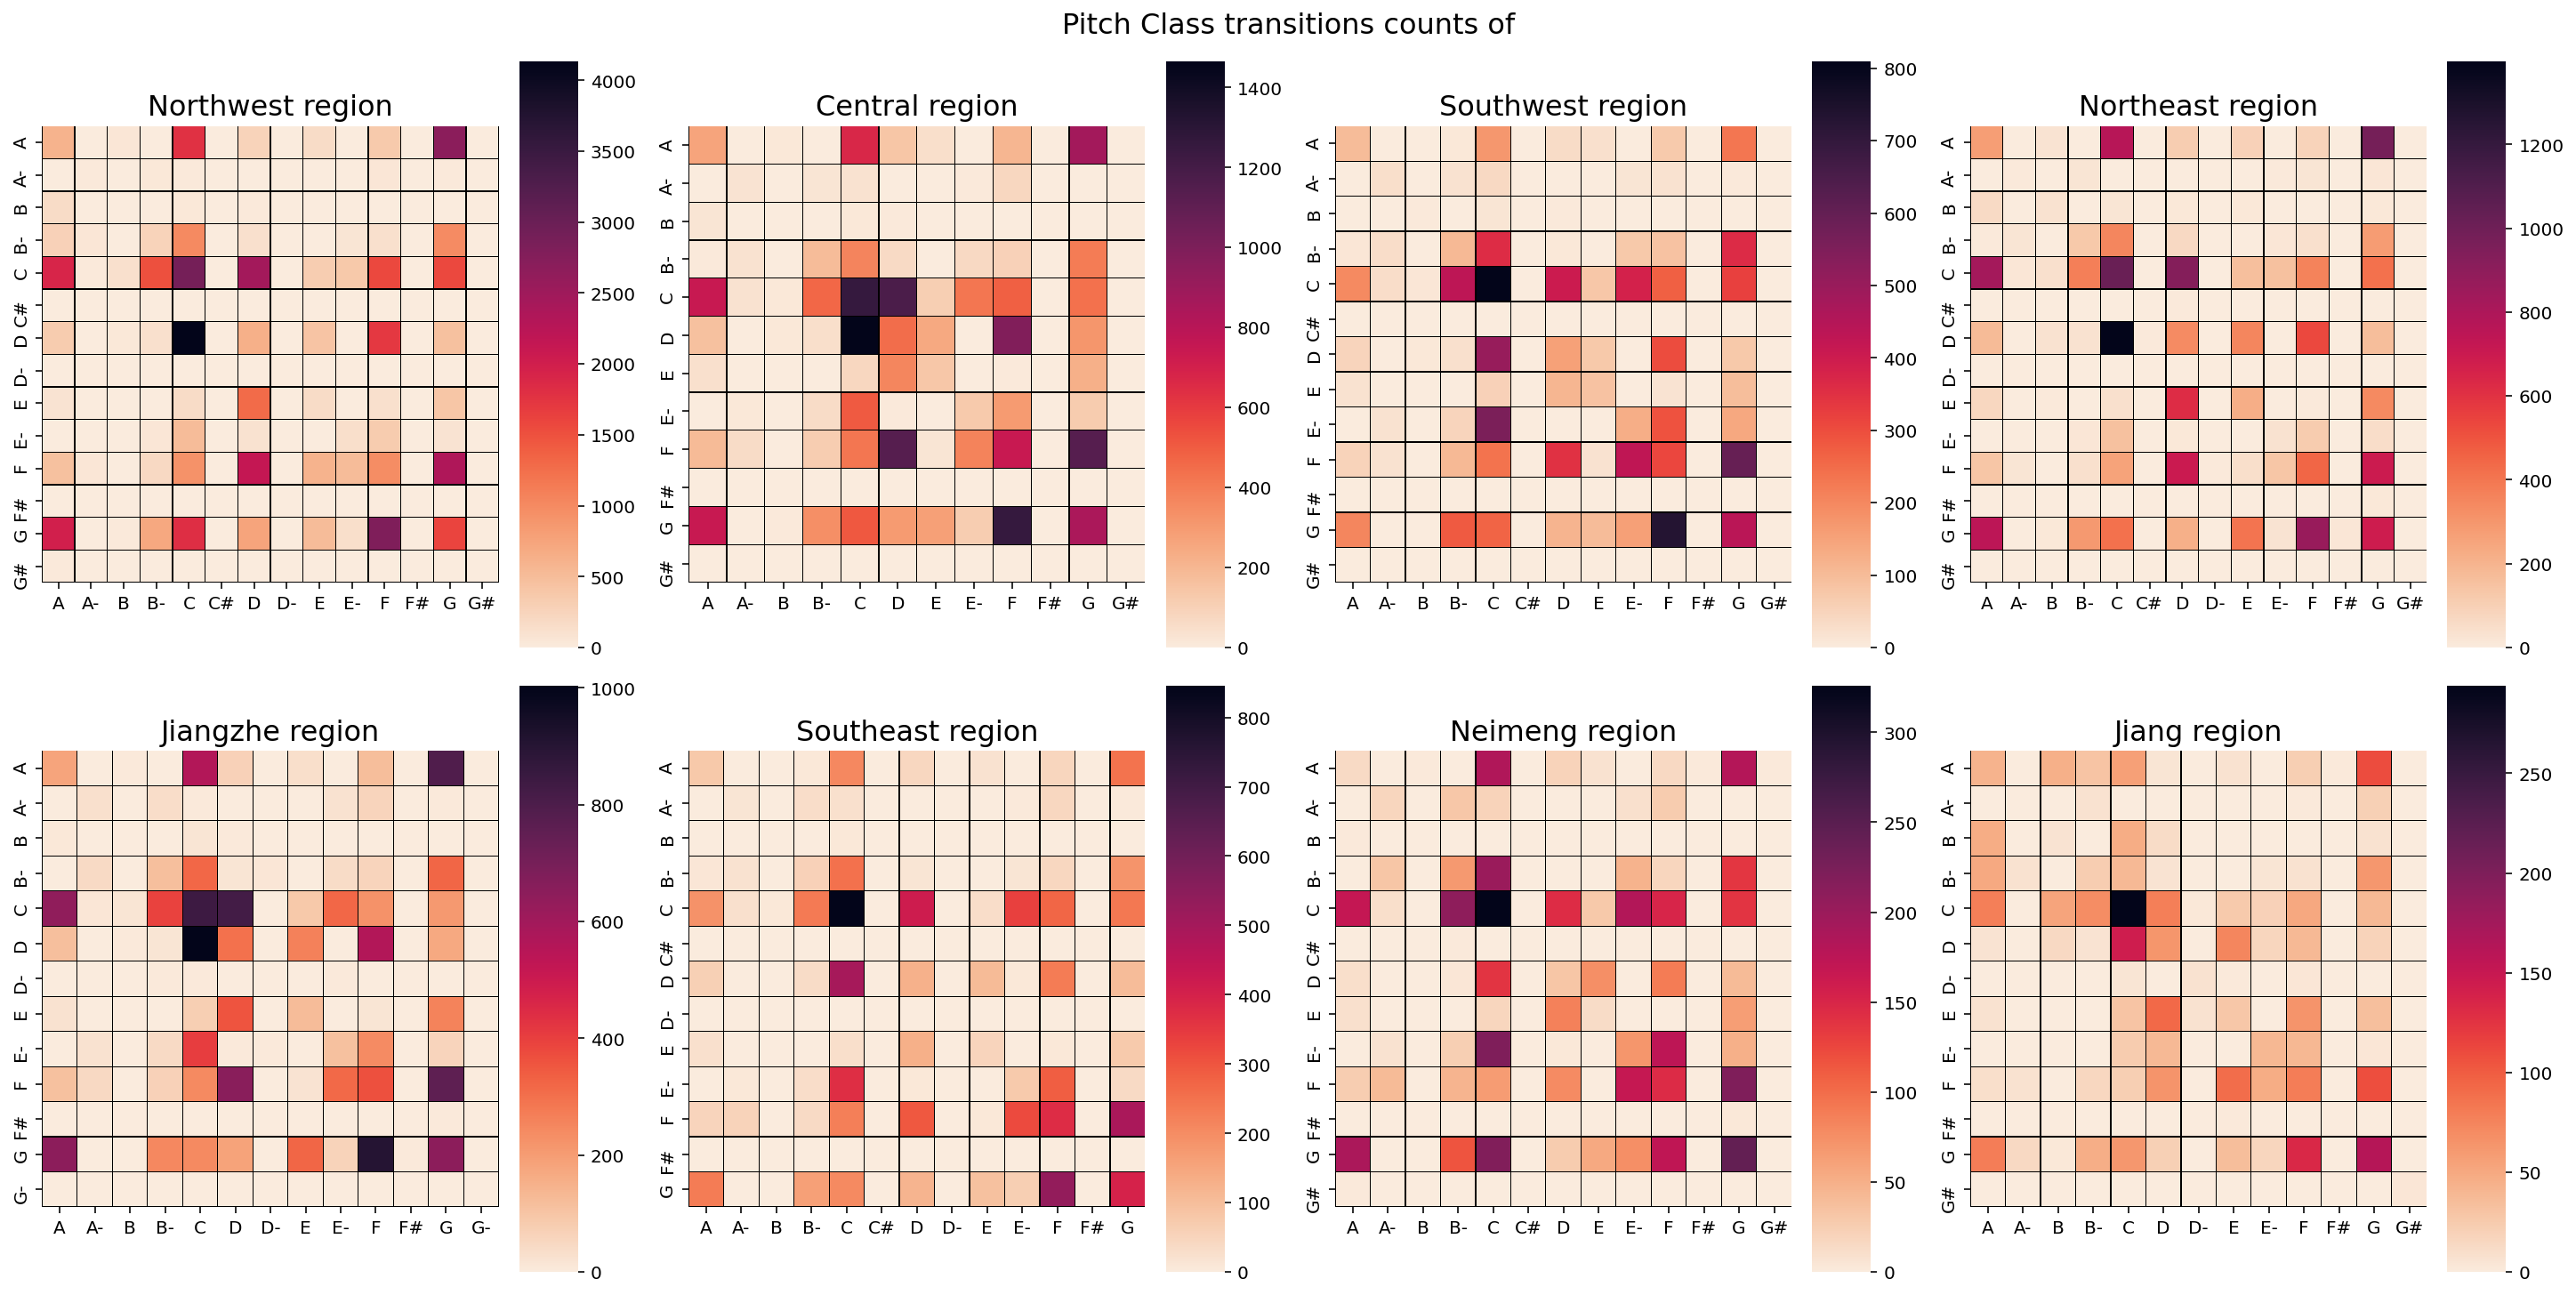

In [253]:
plt.rcParams["figure.figsize"] = (20, 10)
colormap = sns.color_palette("rocket_r", as_cmap=True)
fig, axes = plt.subplots(2,4, constrained_layout=True)
fig.suptitle("Pitch Class transitions counts of", fontsize = 16)
for gloc, ax in zip(geo_divisions, axes.flat):
    
    sorted_probs = sort_dict(pitchclass_transition_absolute[gloc])
    gloc_matrix = pd.DataFrame.from_dict(sorted_probs).T.fillna(0)
    gloc_matrix = gloc_matrix.reindex(sorted(gloc_matrix.columns), axis=1)
    
    sns.heatmap(gloc_matrix, cmap= colormap, square=True, linecolor='black', linewidths=0.1, vmin=0,ax=ax)
    ax.set_title("{} region".format(gloc), fontdict={'fontsize': 16})

From these heatmaps, we can observe that most of the transitions are centred around `C` i.e. the tonic, and a transition from *C* to *C* is the second most prevalent if not the first most prevalent across the regions. Additionally, we see that *G* transits to *F* with higher probability than others in all regions except Neimeng and Jiang where it transits to *G* with high probability followed by *F*. Lastly, we see that the Subdominant i.e. the *F* transits to *D* and *G* with similar probability except in Neimeng and Jiang regions.

### Intervals

While the distribution of intervals is visible on the plots above, it is more convenient to display them as histograms. This can be easily done by using the same helper function as for the scale degrees distributions, only using the statistics of the interval this time.

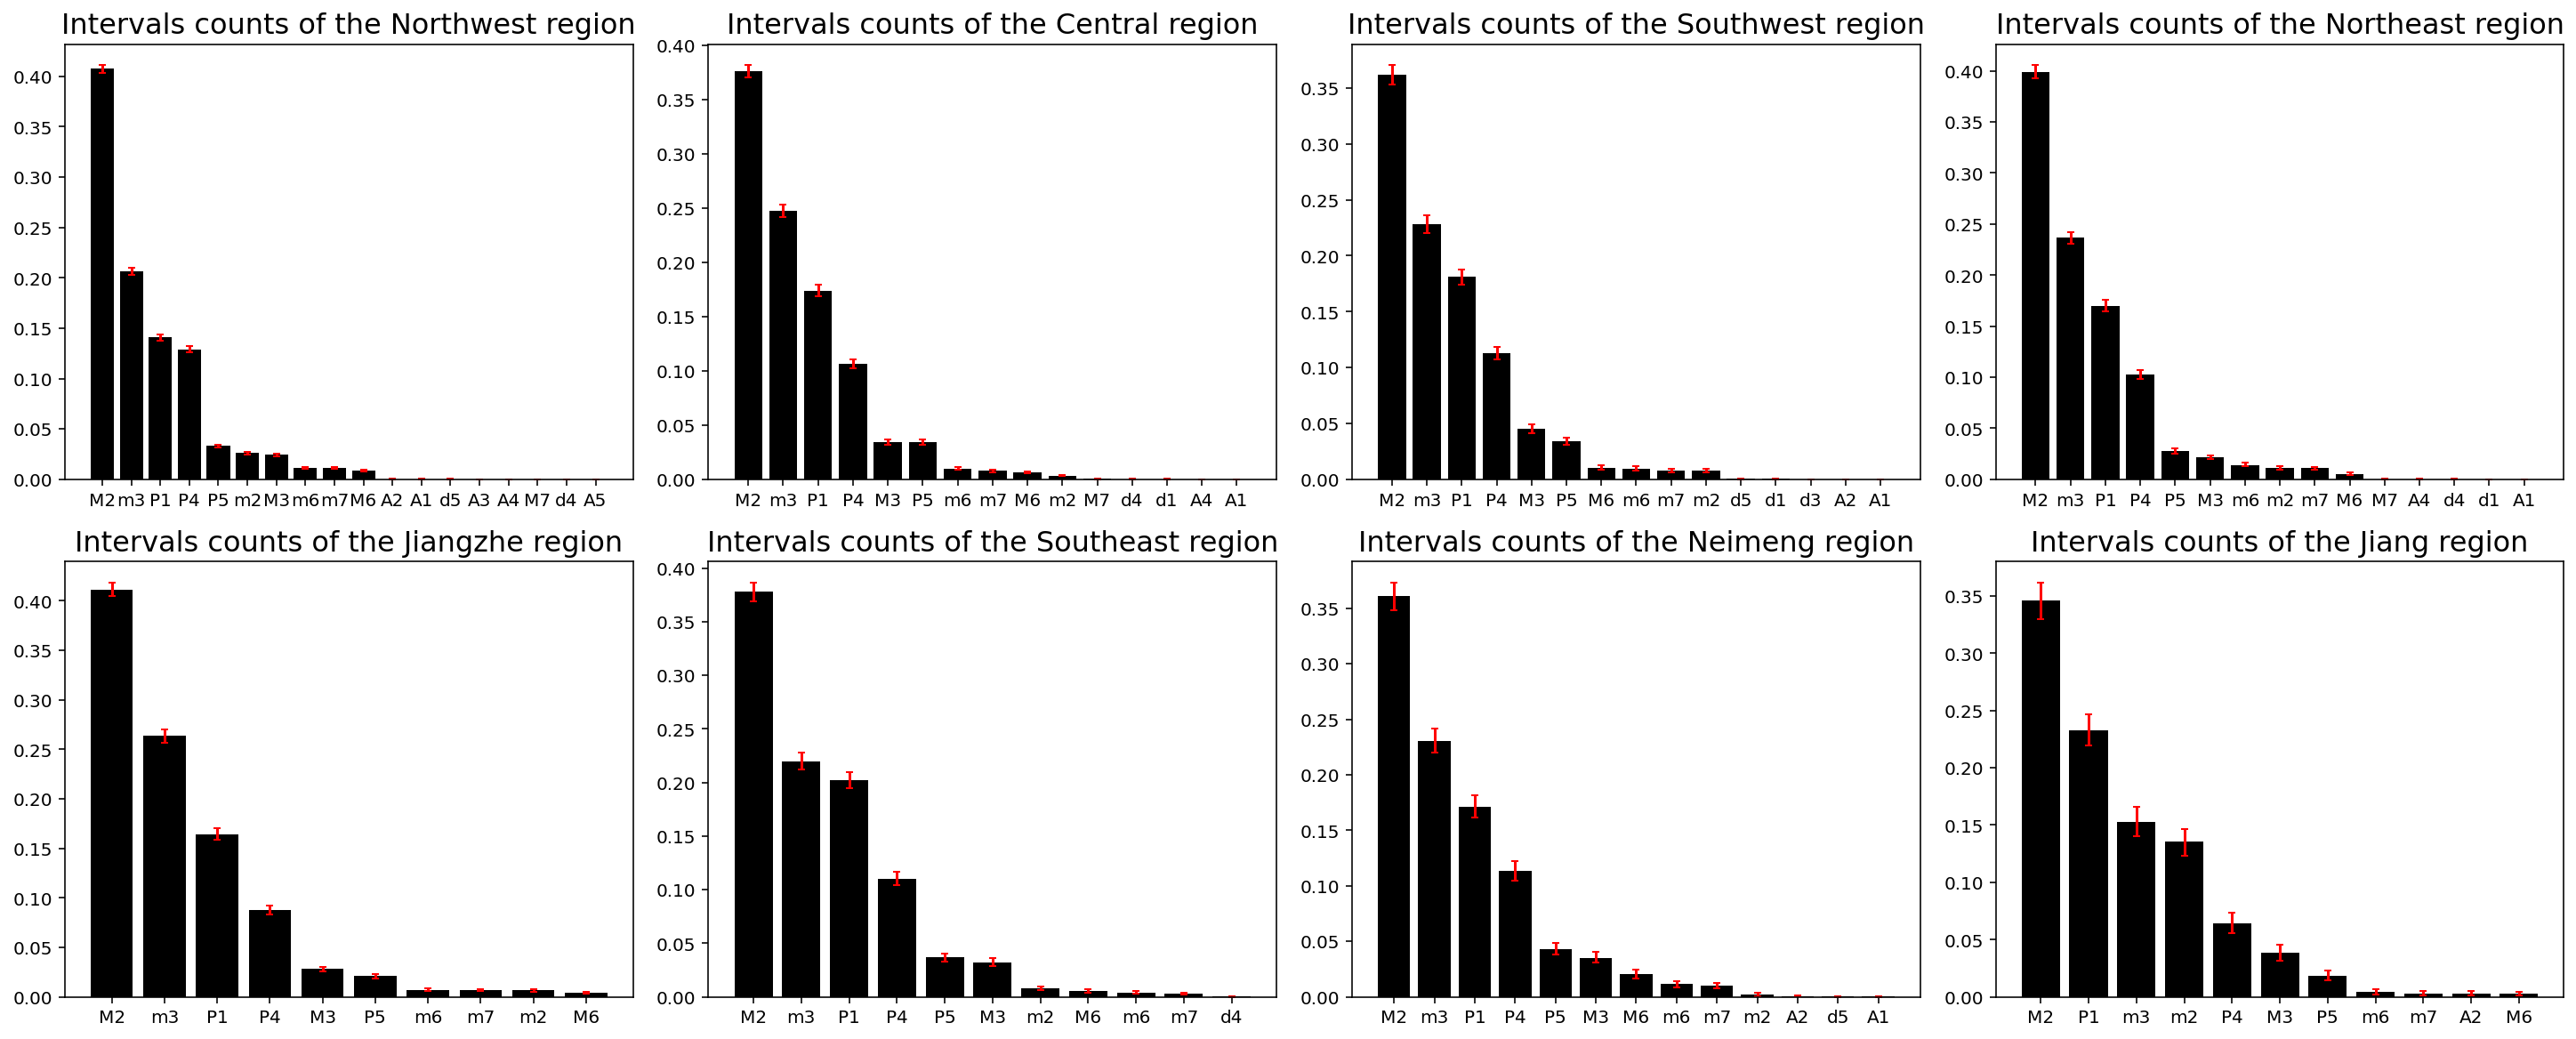

In [231]:
plot_region_stat_counts(region_intervals_stat, log_y=False, figsize=(20,8), title="Intervals counts of the {} region")

This analysis shows a great similarity between all regions as the major second is the most used intervals and, except for a single region, it is followed by the minor third. Moreover, the perfect unison most often comes as the third most used interval.

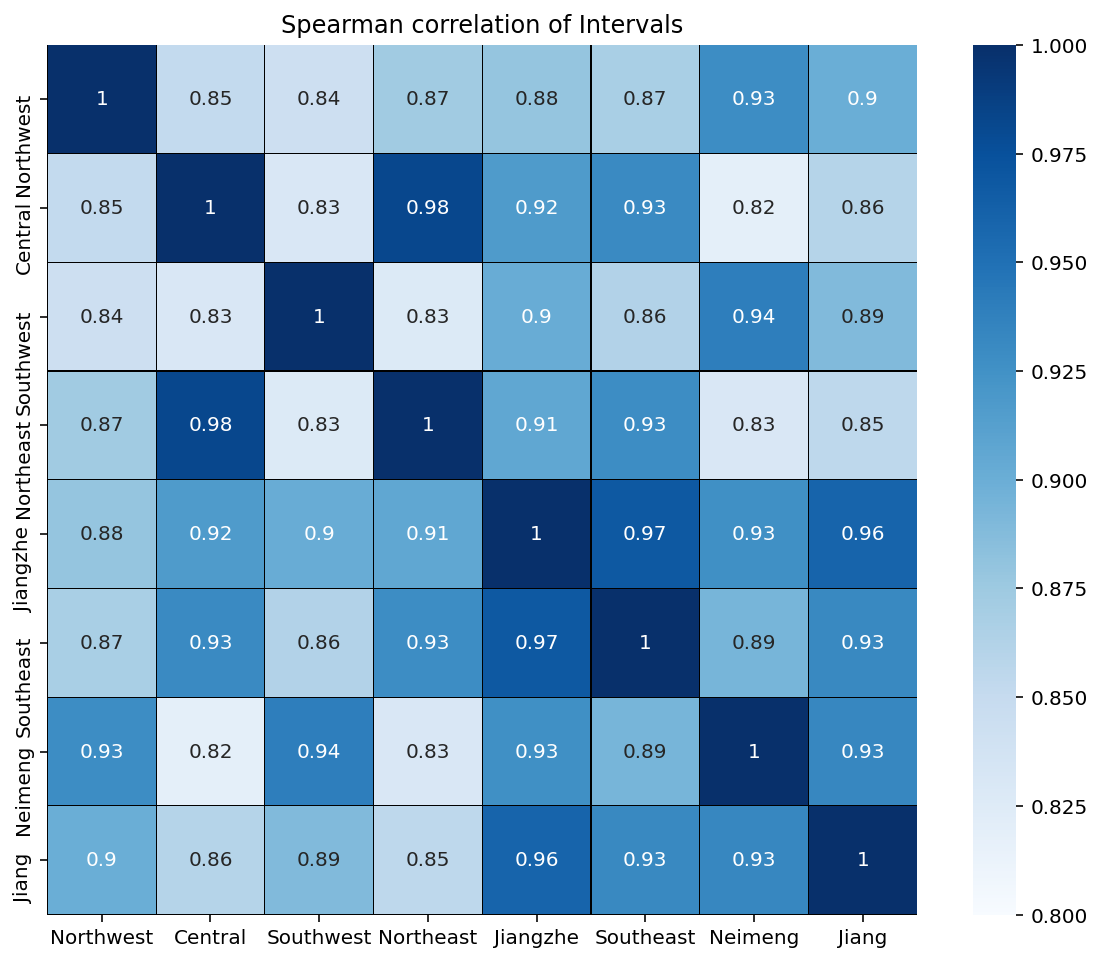

In [254]:
plot_statistical_comparision(region_intervals_stat, intervals_defcount, vmin=0.8, title="Intervals")

Along the lines of the barplots, we see a similarity between the regions in intervals usage. However, the proporation of usage is different, which can be seen in bar plots as well and quantified using the Spearman correlation.

- For the Northwest region, the highest positive relation is intervals usage is found with Neimeng and lowest negative relation with Southwest.
- For the Central region, the highest positive relation is intervals usage is found with Northeast and lowest negative relation with Neimeng.
- For the Southwest region, the highest positive relation is intervals usage is found with Neimeng and lowest negative relation with Central/Northeast.
- For the Northeast region, the highest positive relation is intervals usage is found with Central and lowest negative relation with Southwest/Neimeng.
- For the Jiangzhe region, the highest positive relation is intervals usage is found with Southeast and lowest negative relation with Northwest.
- For the Southeast region, the highest positive relation is intervals usage is found with Jiangzhe and lowest negative relation with Southwest.
- For the Neimeng region, the highest positive relation is intervals usage is found with Southwest and lowest negative relation with Central.
- For the Jiang region, the highest positive relation is intervals usage is found with Jiangzhe and lowest negative relation with Northeast.

### Transitions using local beat strengths

Previously, we have seen the transitions between the pitch classes without considering the metrical position. Now, we repeat the analysis while considering the metrical position. We define two types of metrical positions called `Strong` and `Weak`. For each transition between two notes, the note with lower beat strength when compared with the other note is considered to be in a weak metrical position and the note with high beat strength is considered to be in a strong metrical position. If the beat strengths are the same for both notes, then they are said to have equal beat strengths. Thus we arrive at three possible transitions 1) transition from weak to a strong metrical position; 2) from strong to weak metrical position and 3) between equal metrical positions. These three transitions are plotted as separate histograms below for each region. We observe from the previous section on pitch-class transitions that many entries are zero or very small values. Thus, to be able to see the important information while discarding the less informative entries we only consider the transitions between `C, D, E, G, A, E-, A- and B-` as the modes of the pentatonic scale are composed by these scale degrees when translated to C.

In [6]:
selected_notes = ["C", "D", "E", "G", "A", "E-", "A-", "B-"]

pitchclass_transition_localbs_S2W_def_count =  {pc1+"_S":{pc2+"_W":0 for pc2 in selected_notes} for pc1 in selected_notes}
pitchclass_transition_localbs_W2S_def_count =  {pc1+"_W":{pc2+"_S":0 for pc2 in selected_notes} for pc1 in selected_notes}

In [7]:
pitchclass_transition_localbs_S2W = {geo_region: {} for geo_region in geo_divisions}
pitchclass_transition_localbs_W2S = {geo_region: {} for geo_region in geo_divisions}
pitchclass_transition_localbs_E2E = {geo_region: {} for geo_region in geo_divisions}


for index, row in CFS_full.iterrows():
    prev_pitchclass = None
    region = row["geo_division"]
    
    for i in range(len(row["pitchclasses_transposed"])):
        
        curr_bs = row["beat_strengths"][i]
        curr_pitchclass = row["pitchclasses_transposed"][i]
        if prev_pitchclass is not None:
            
            if ((curr_pitchclass in selected_notes) and (prev_pitchclass in selected_notes)):
            
                if curr_bs > prev_bs:

                    curr_node_name = curr_pitchclass + "_S"
                    prev_node_name = prev_pitchclass + "_W"

                    if prev_node_name not in pitchclass_transition_localbs_W2S[region]:
                        pitchclass_transition_localbs_W2S[region][prev_node_name] = {}

                    if curr_node_name not in  pitchclass_transition_localbs_W2S[region][prev_node_name]:
                        pitchclass_transition_localbs_W2S[region][prev_node_name][curr_node_name] = 1
                    else:
                        pitchclass_transition_localbs_W2S[region][prev_node_name][curr_node_name] += 1

                elif curr_bs < prev_bs:
                    curr_node_name = curr_pitchclass + "_W"
                    prev_node_name = prev_pitchclass + "_S"

                    if prev_node_name not in pitchclass_transition_localbs_S2W[region]:
                        pitchclass_transition_localbs_S2W[region][prev_node_name] = {}

                    if curr_node_name not in  pitchclass_transition_localbs_S2W[region][prev_node_name]:
                        pitchclass_transition_localbs_S2W[region][prev_node_name][curr_node_name] = 1
                    else:
                        pitchclass_transition_localbs_S2W[region][prev_node_name][curr_node_name] += 1

                else:
                    curr_node_name = curr_pitchclass + "_E"
                    prev_node_name = prev_pitchclass + "_E"

                    if prev_node_name not in pitchclass_transition_localbs_E2E[region]:
                        pitchclass_transition_localbs_E2E[region][prev_node_name] = {}

                    if curr_node_name not in  pitchclass_transition_localbs_E2E[region][prev_node_name]:
                        pitchclass_transition_localbs_E2E[region][prev_node_name][curr_node_name] = 1
                    else:
                        pitchclass_transition_localbs_E2E[region][prev_node_name][curr_node_name] += 1
            
        prev_pitchclass = curr_pitchclass
        prev_bs = curr_bs
        
# Augument the pitch class transistions with the default count of zero for the transistion not existing.
for geo_region in pitchclass_transition_localbs_S2W:
    pitchclass_transition_localbs_S2W[geo_region] = {**pitchclass_transition_localbs_S2W_def_count, **pitchclass_transition_localbs_S2W[geo_region]}

for geo_region in pitchclass_transition_localbs_W2S:
    pitchclass_transition_localbs_W2S[geo_region] = {**pitchclass_transition_localbs_W2S_def_count, **pitchclass_transition_localbs_W2S[geo_region]}

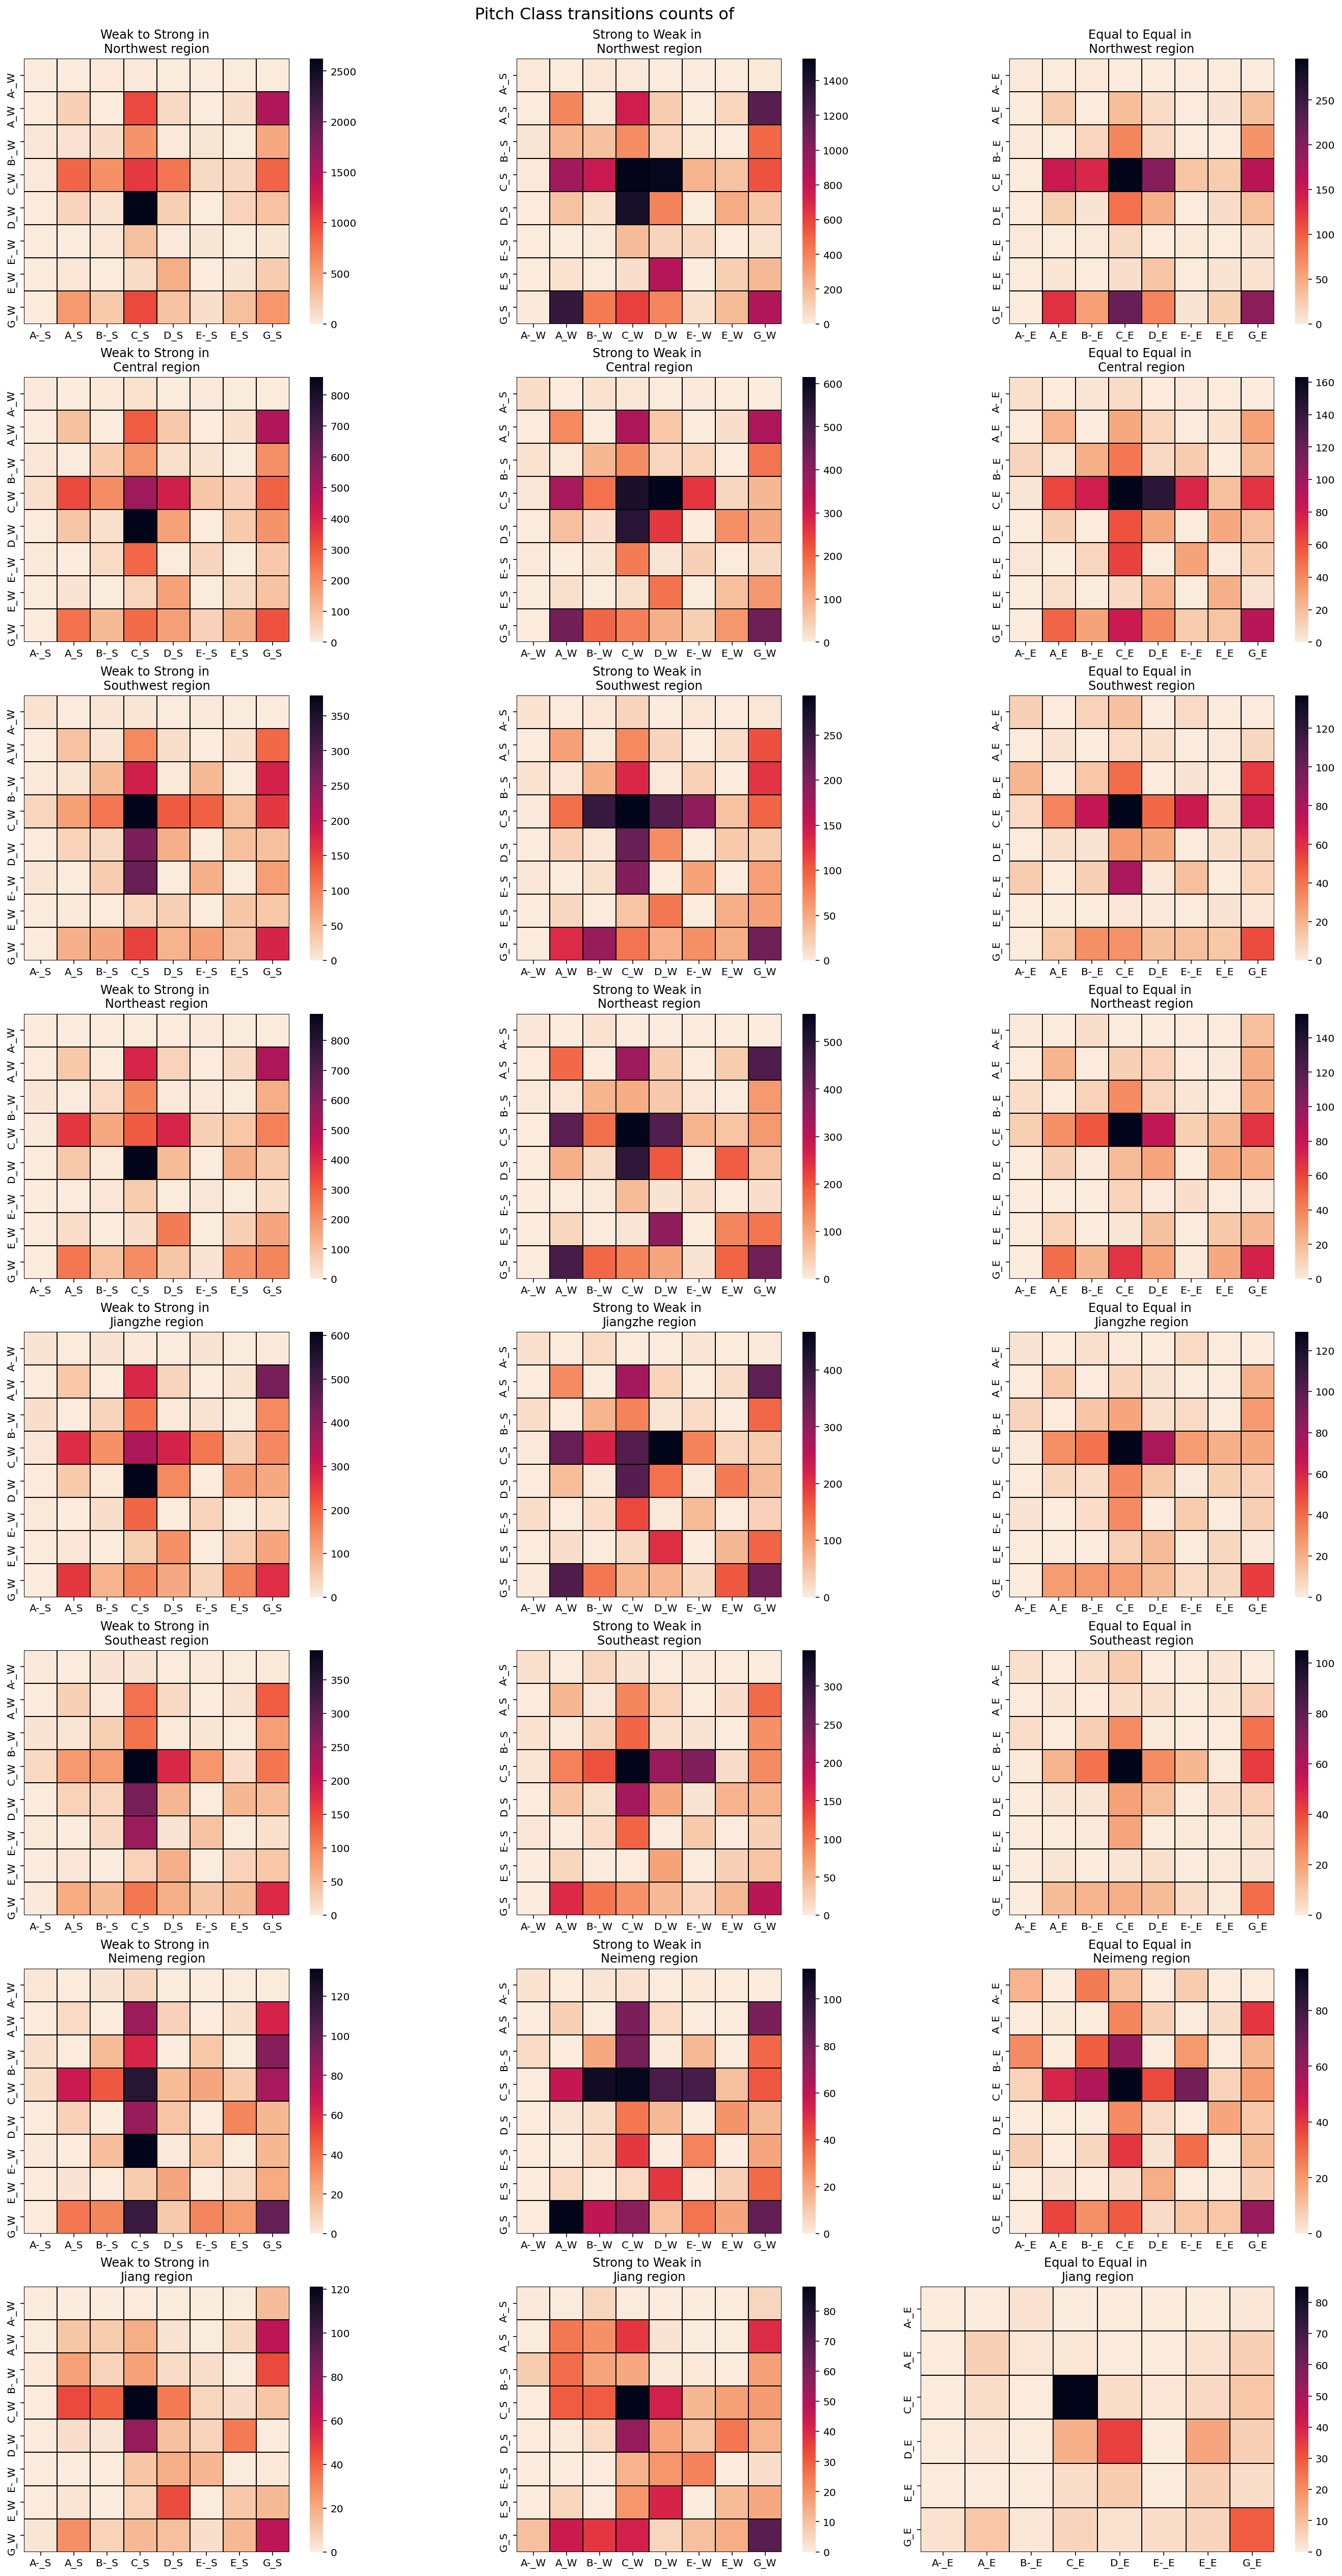

In [10]:
plt.rcParams["figure.figsize"] = (20, 35)
colormap = sns.color_palette("rocket_r", as_cmap=True)
fig, axes = plt.subplots(8,3, constrained_layout=True)
fig.suptitle("Pitch Class transitions counts of", fontsize = 16)
for ind, gloc in enumerate(geo_divisions):
    
    sorted_probs = sort_dict(pitchclass_transition_localbs_W2S[gloc])
    gloc_matrix = pd.DataFrame.from_dict(sorted_probs).T.fillna(0)
    gloc_matrix = gloc_matrix.reindex(sorted(gloc_matrix.columns), axis=1)
    
    ax1 = sns.heatmap(gloc_matrix, cmap= colormap, square=True, linecolor='black', linewidths=0.1, vmin=0, ax=axes[ind][0])
    ax1.set_title("Weak to Strong in \n{} region".format(gloc))
    
    sorted_probs = sort_dict(pitchclass_transition_localbs_S2W[gloc])
    gloc_matrix = pd.DataFrame.from_dict(sorted_probs).T.fillna(0)
    gloc_matrix = gloc_matrix.reindex(sorted(gloc_matrix.columns), axis=1)
    
    ax2 = sns.heatmap(gloc_matrix, cmap= colormap, square=True, linecolor='black', linewidths=0.1, vmin=0, ax=axes[ind][1])
    ax2.set_title("Strong to Weak in \n{} region".format(gloc))
    
    sorted_probs = sort_dict(pitchclass_transition_localbs_E2E[gloc])
    gloc_matrix = pd.DataFrame.from_dict(sorted_probs).T.fillna(0)
    gloc_matrix = gloc_matrix.reindex(sorted(gloc_matrix.columns), axis=1)
    
    ax3 = sns.heatmap(gloc_matrix, cmap= colormap, square=True, linecolor='black', linewidths=0.1, vmin=0, ax=axes[ind][2])
    ax3.set_title("Equal to Equal in \n{} region".format(gloc))

From these transitions involving metrical structure, we observe that the notes in weak metrical position transit to a tonic and Dominant at the higher metrical position in all the regions. In the case of notes starting at a higher strength, they transit to multiple weaker positions but are majorly concentrated around the dominant and super dominant in weak positions. At the same time in notes with equal strengths, we observe that the landing note is mostly the tonic.

#### Asymmetry in Transitions using local beat strengths

In order to understand the asymmetry in transitions, we look the difference in the number of transitions from strong to weak metrical position to weak to strong metrical position.

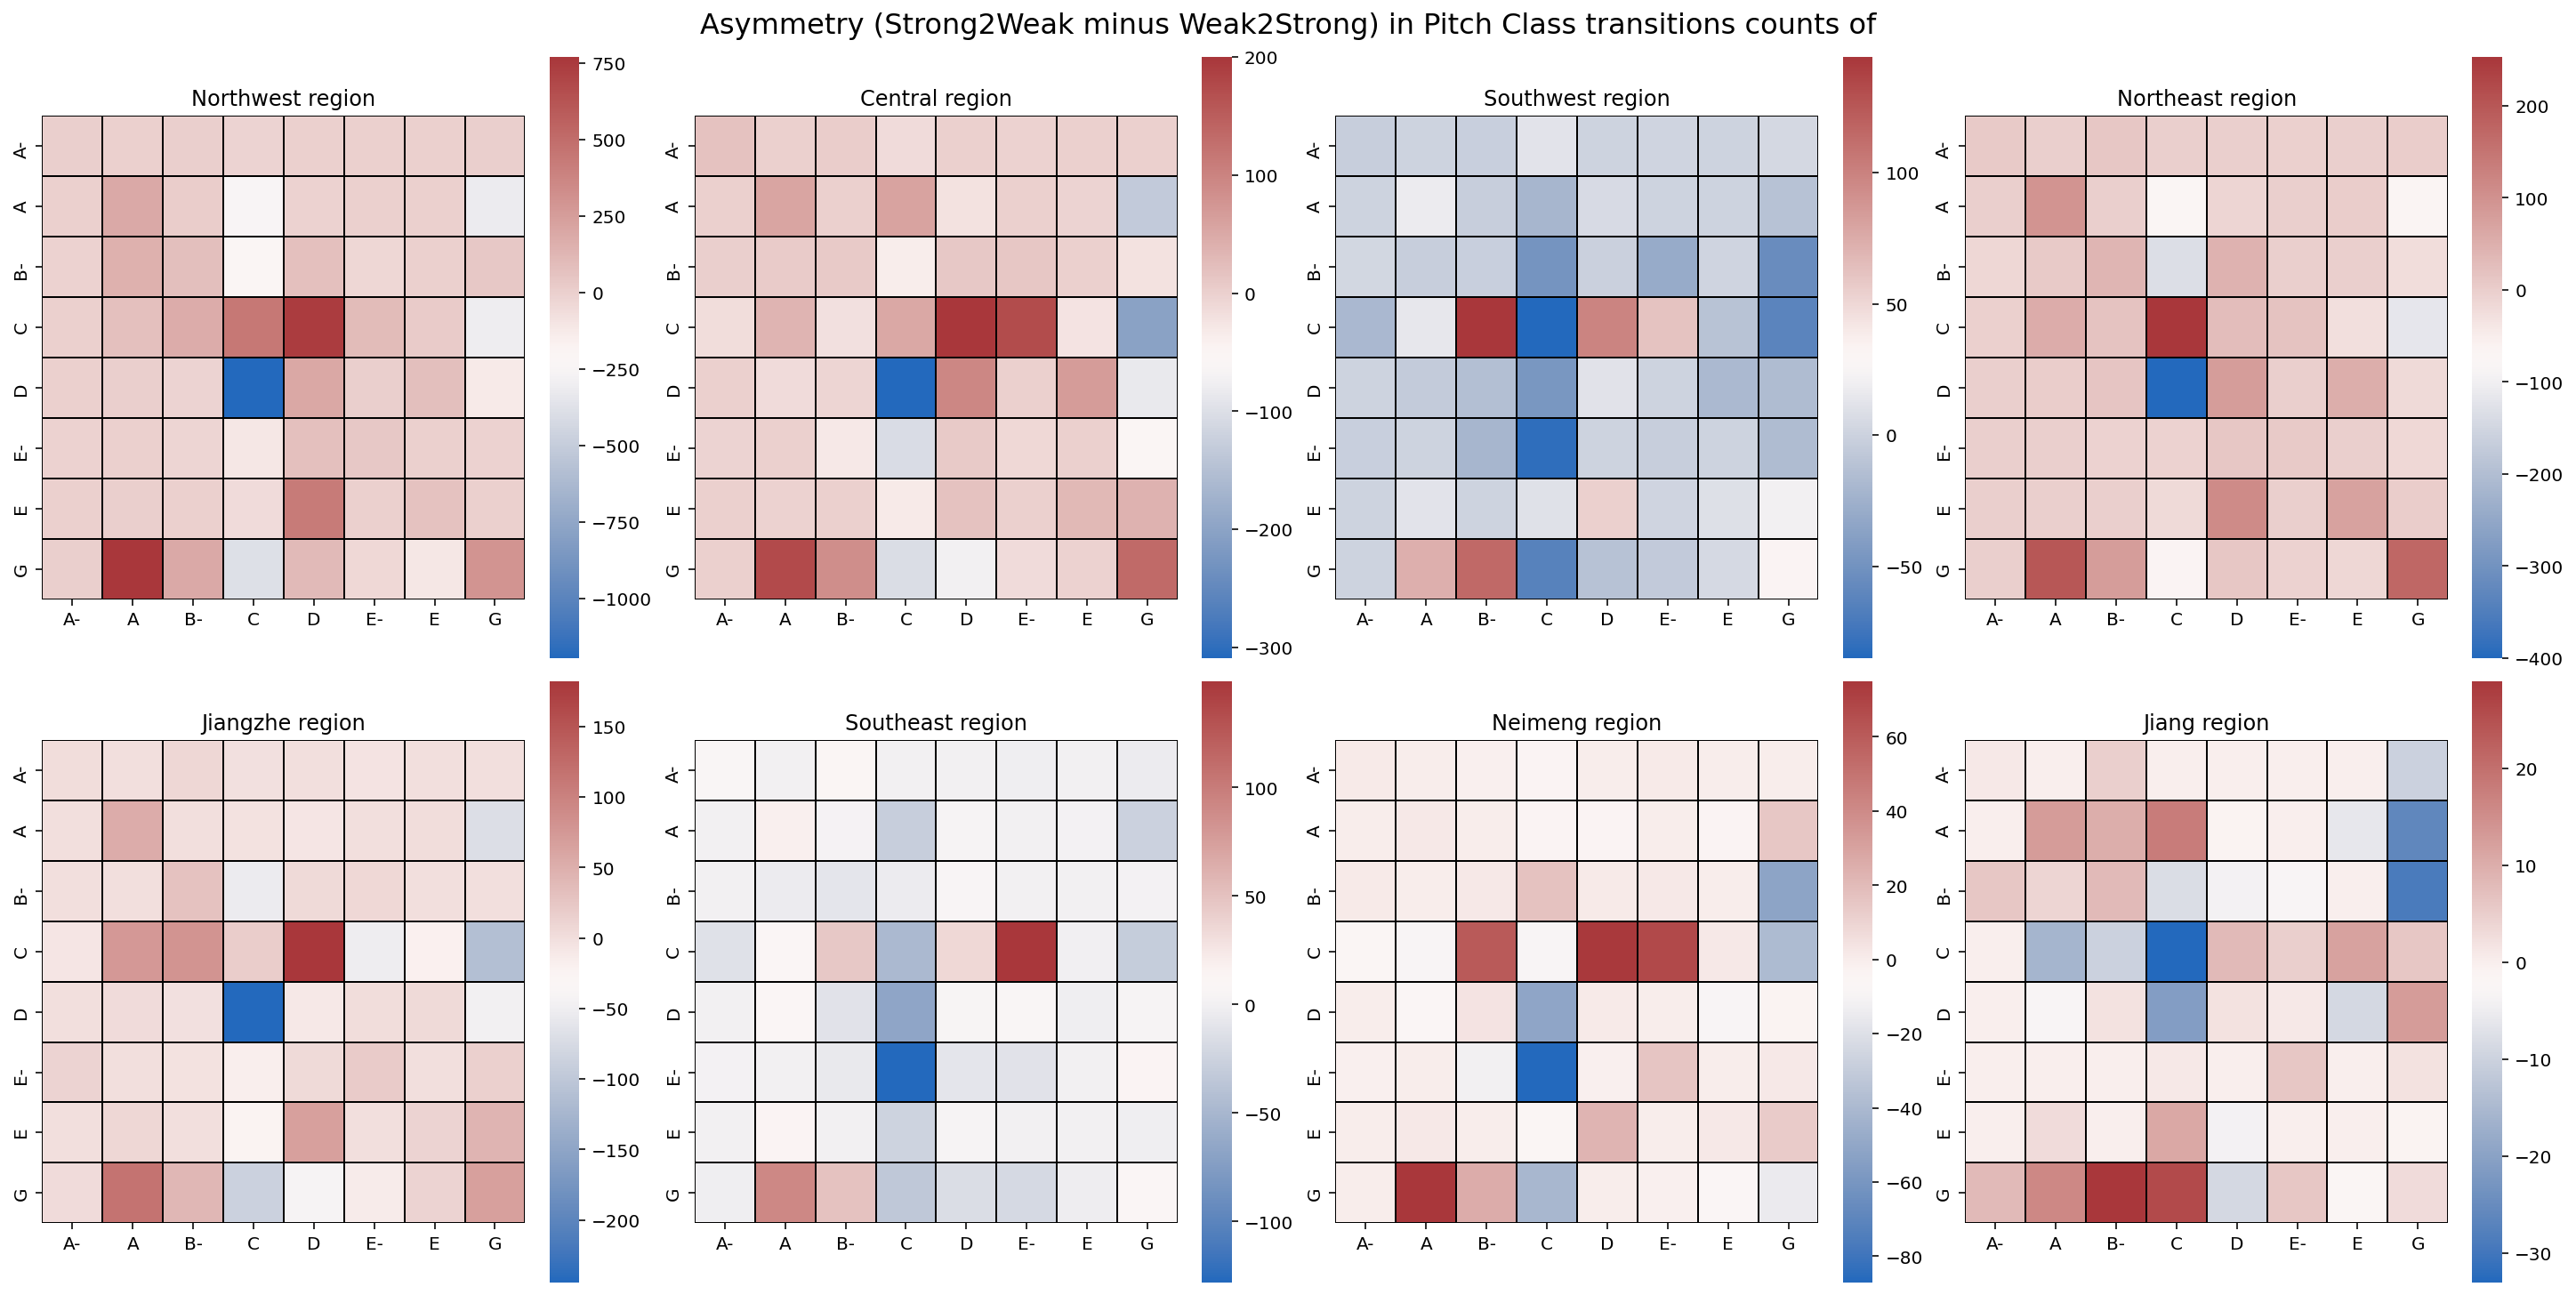

In [25]:
region_pitch_asymmetry = {}


plt.rcParams["figure.figsize"] = (20, 10)
colormap = sns.color_palette("vlag", as_cmap=True)
fig, axes = plt.subplots(2,4, constrained_layout=True)
fig.suptitle("Asymmetry (Strong2Weak minus Weak2Strong) in Pitch Class transitions counts of", fontsize = 16)
for ax, gloc in zip(axes.flat, geo_divisions):
    
    sorted_probs_W2S = sort_dict(pitchclass_transition_localbs_W2S[gloc])
    gloc_matrix_W2S = pd.DataFrame.from_dict(sorted_probs_W2S).T.fillna(0)
    gloc_matrix_W2S = gloc_matrix_W2S.reindex(sorted(gloc_matrix_W2S.columns), axis=1)
    gloc_matrix_W2S.rename(columns=lambda s: str(s)[:-2], index=lambda s: str(s)[:-2], inplace=True)
    
        
    sorted_probs_S2W = sort_dict(pitchclass_transition_localbs_S2W[gloc])
    gloc_matrix_S2W = pd.DataFrame.from_dict(sorted_probs_S2W).T.fillna(0)
    gloc_matrix_S2W = gloc_matrix_S2W.reindex(sorted(gloc_matrix_S2W.columns), axis=1)
    gloc_matrix_S2W.rename(columns=lambda s: str(s)[:-2], index=lambda s: str(s)[:-2], inplace=True)
    
    gloc_matrix = gloc_matrix_S2W.subtract(gloc_matrix_W2S)
    
    region_pitch_asymmetry[gloc] = gloc_matrix.stack().values
    
    ax_ = sns.heatmap(gloc_matrix, cmap= colormap, square=True, linecolor='black', linewidths=0.1, ax=ax)
    ax_.set_title("{} region".format(gloc))
    

Looking at the asymmetry plots, we observe that the transistions from strong to weak positions are predominent in all regions except for Southwest and Southeast regions (in particular, for Southwest region). To compare the regions, statistically, the asymmetry matrix is flattened for each region and then compared with other regions using Spearman Rank correlation.

Text(0.5, 1.0, 'Spearman correlation of Pitch Class asymmetry')

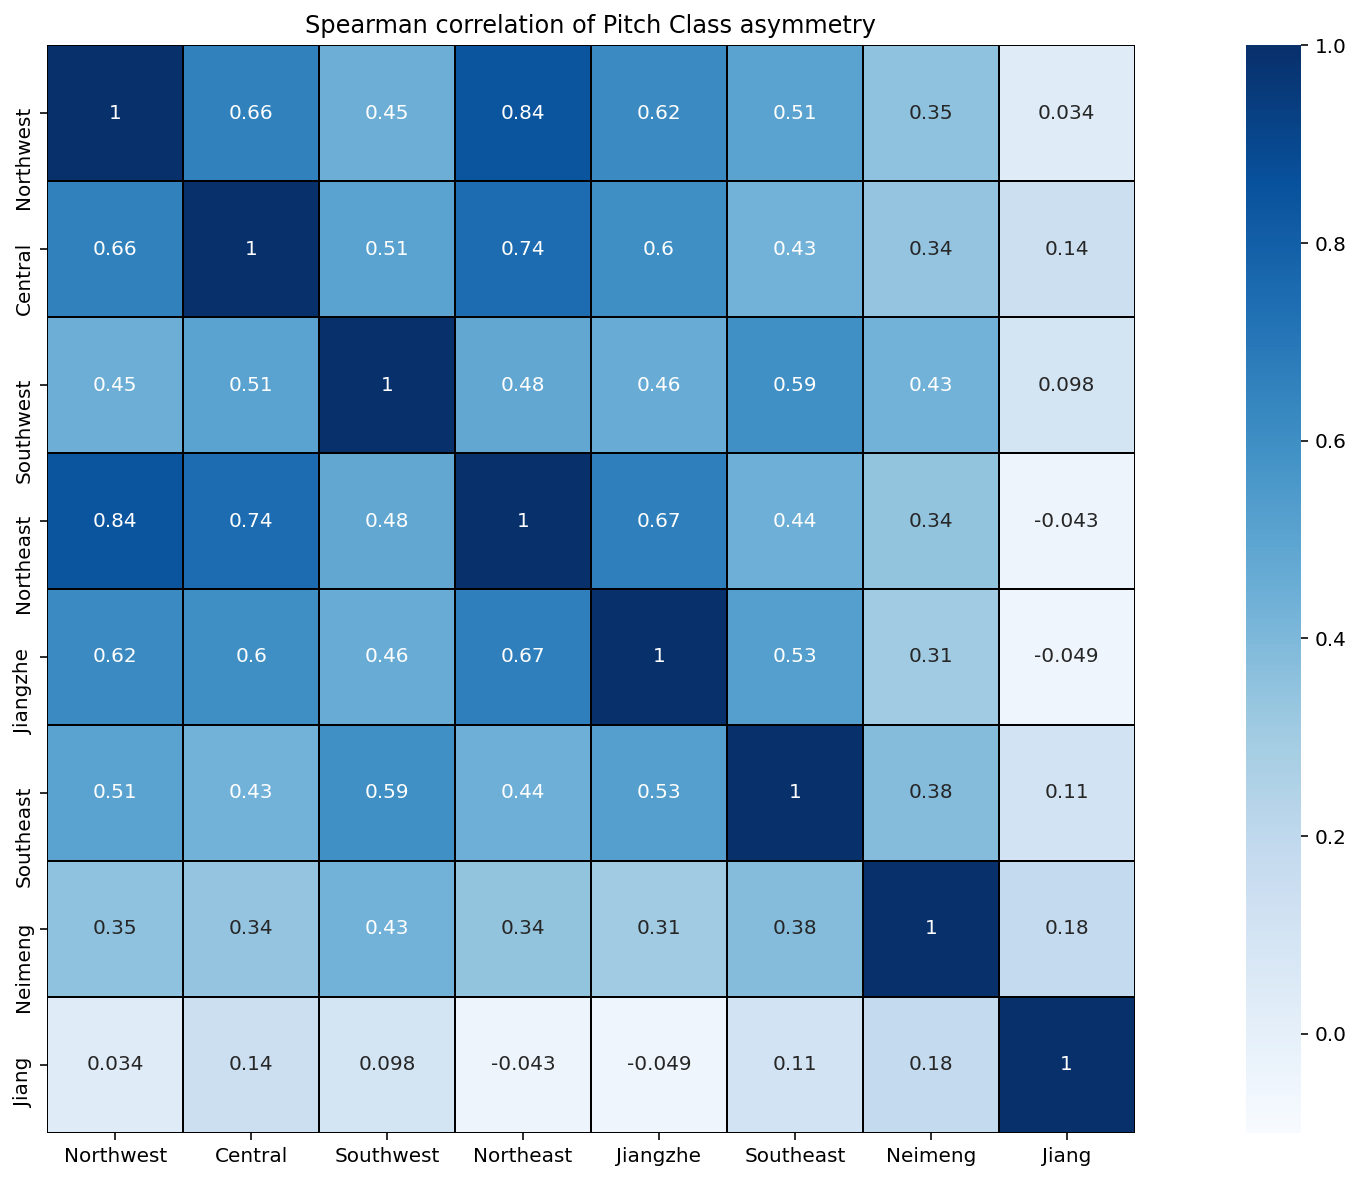

In [36]:
colormap = sns.color_palette("Blues", as_cmap=True)
spearman_corrdf = region_pitch_asymmetry_df.corr(method="spearman")

ax = sns.heatmap(spearman_corrdf, cmap= colormap, square=True, linecolor='black', linewidths=0.1, vmin=-0.1, annot=True)
ax.set_title("Spearman correlation of {}".format("Pitch Class asymmetry"))

When comparing ranks of the asymmetry values, we get some differences that were not there before. We do not see a strong positive relationship between any two regions. Nevertheless, there are many positive relationships and very small negative ones.

- For the Northwest region, the positive relation is found with Northeast and lowest relation with Jiang.
- For the Central region, the positive relation is found with Northeast and lowest relation with Jiang.
- For the Southwest region, the positive relation is found with Southeast and lowest relation with Jiang.
- For the Northeast region, th positive relation is found with Northwest and lowest *small negative* relation with Jiang.
- For the Jiangzhe region, the positive relation is found with Northeast and lowest *small negative* relation with Jiang.
- For the Southeast region, the positive relation is found with Southwest and lowest relation with Jiang.
- For the Neimeng region, the positive relation is found with Southwest and lowest relation with Jiang.
- For the Jiang region, the highest small positive relation is found with Neimeng and lowest small negative relation with Jiangzhe.


Jiang region, which is far away from all the other regions, uses the weak/strong to strong/weak transistions very differently than all others. 


### Scale degree flexibility

In *Sweet Anticipation*, Huron defines the flexibility of a scale degree as the "uncertainty that attends the continuation following a given pitch". For example, if a pitch is always followed by the same one, its uncertainty will be null. However, if it is equally probable to be followed by any pitch, then its uncertainty is maximal.

This measure of uncertainty can be computed using the Shannon-Weaver equation for the entropy, where the binary entropy $H$ of a random variable $X$ is computed as $H(X) = -\sum_{i=1}^{n}P(X_i)\log_2(P(X_i))$. In this context, $X$ will be the random variable defining the probability that a certain pitch translates to another one. This variable is called `pitchclass_transition_probability` in the code below. These probabilities can be easily computed by dividing the transition counts computed earlier by the total amount of transitions.

In [259]:
pitchclass_transition_probability = {geo_region: {} for geo_region in geo_divisions}
for region, transitions in pitchclass_transition_absolute.items():
    for start_note, transition in transitions.items():
        pitchclass_transition_probability[region][start_note] = {}
        for landing_note, count in transition.items():
            pitchclass_transition_probability[region][start_note][landing_note] = count/sum(transition.values())

We can now use the definition of the entropy to compute it from these probabilities.

In [260]:
entropies = {geo_region: {} for geo_region in geo_divisions}
for region, transitions in pitchclass_transition_probability.items():
    for start_note, probabilities in transitions.items():
        entropies[region][start_note] = -sum([p*math.log2(p) for p in probabilities.values()])

Finally, we can plot the flexibility of each scale degree for each region after having sorted them.

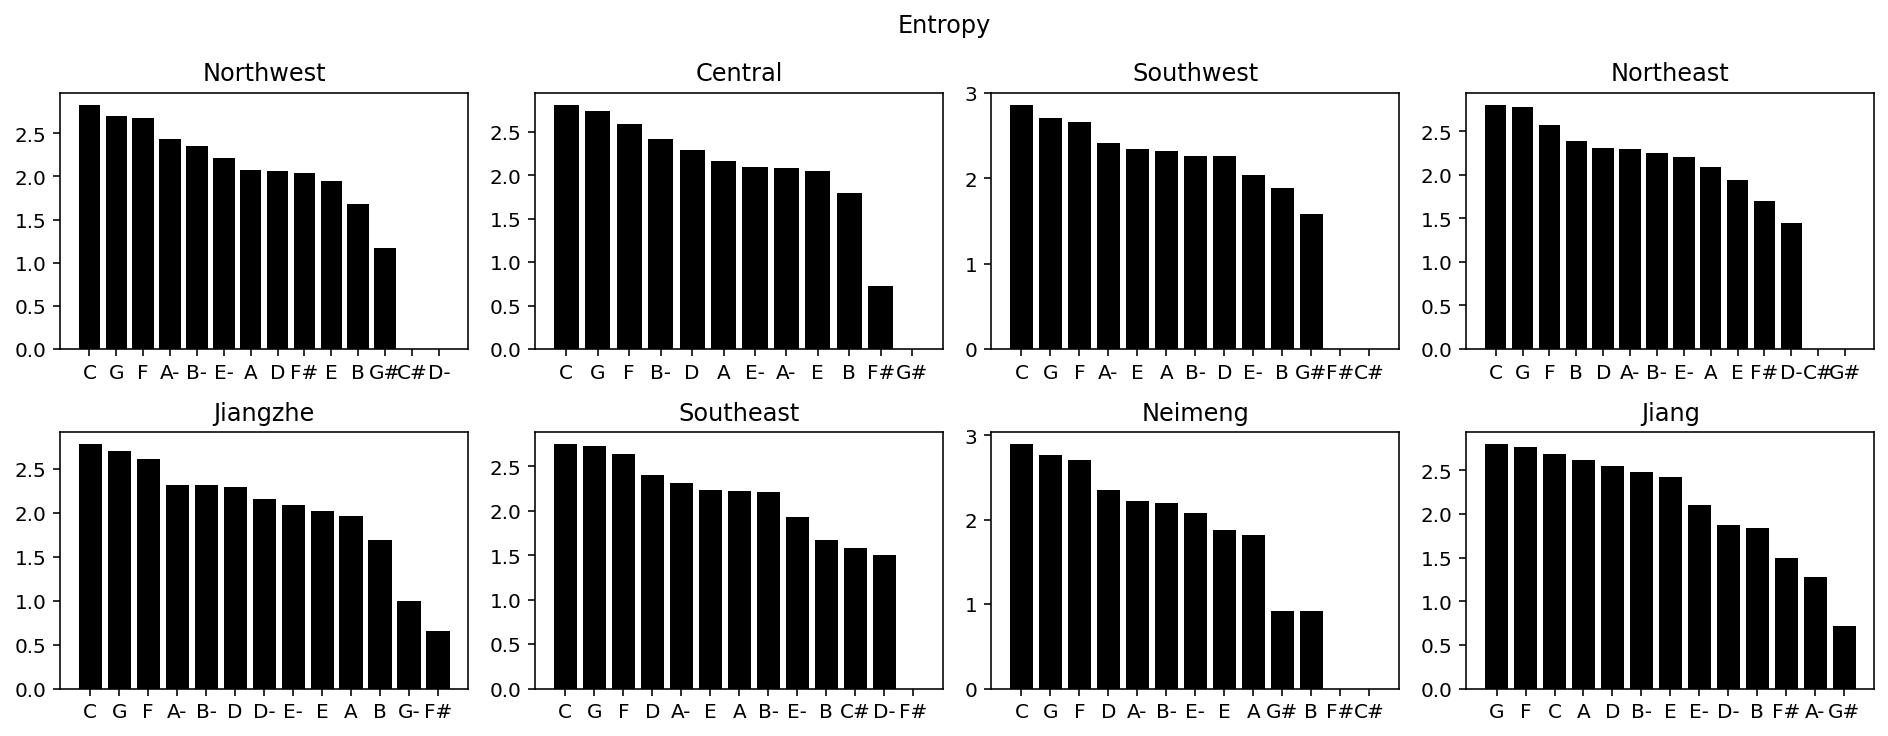

In [261]:
plt.rcParams["figure.figsize"] = (13, 5)
fig, axarr = plt.subplots(2, 4, constrained_layout=True)
fig.suptitle("Entropy")
for gloc, ax in zip(geo_divisions, axarr.flat):
    ax.set_title(gloc)
    sorted_entropies = {key: value for (key, value) in sorted(entropies[gloc].items(), key=lambda x: x[1], reverse=True)}    
    x = list(sorted_entropies.keys())
    y=list(sorted_entropies.values())
    ax.bar(x, y, color='black')
    ax.set_title("{}".format(gloc))

In these results, we can observe that, as in Huron's study, the most central scale degrees also have the highest flexibility, as the dominant, subdominant, and second are on the top left in each plot. These results not only show a similarity between Western and non-Western Folk songs but also displays great similarity between the CFS of different regions. Therefore, this analysis goes against our hypothesis.

### Stable notes

To investigate the stable notes in each region we perform a plain Markovian random walk using the probability transition matrix generated from the pieces of a given geographical division. A directed graph G is built for music from each region using the pitch class transitions collected from all the pieces belonging to the region. The nodes of the graph are the various notes that are present in the music of the considered region and the edges represent the probability of transition between the nodes. For each geographical division, we choose a random node in the network and transit to a new node based on the transition matrix and collect the nodes visited in the walk. While the length of the walk is determined by the average size of the piece of a given region, the walk is repeated 10,000 for each division. Then, we plot the count of the aggregated nodes per region.

Let A be the adjacency and degree matrices of graph G it will be considered as the transition matrix for the walk. Let $p^{(0)}$ be the state vector (i.e. the i-th component indicates the probability of being at node i) at the beginning of the walk, the first step (walk) can be evaluated as $p^{(1)} = Ap^{(0)}$.

Iteratively, the k-th random walk step can be evaluated as $p^{(k)} = Ap^{(k-1)}$.

In [262]:
def perform_random_walk(transisition_dict, walk_length):
    
    visited = []
    
    graph = nx.DiGraph((k, v, {'weight': weight}) for k, vs in transisition_dict.items() for v, weight in vs.items())
    nodes = list(graph.nodes)
    num_nodes = len(nodes)
    
    # Adjacency matrix
    A = nx.adj_matrix(graph)
    A = A.todense()
    A = np.array(A, dtype = np.float64)

    # define the starting node, randomly
    empty_state = np.zeros(num_nodes)
    random_node = np.random.randint(low = 0, high = num_nodes-1, size = 1)[0]
    empty_state[random_node] = 1
    p = empty_state.reshape(-1,1)
    
    for k in range(walk_length):
        # next state vector
        p = np.dot(A,p)
        # choose the node with higher probability as the visited node
        visited.append(nodes[np.argmax(p)])
    return visited

In [263]:
print("The average length of piece per region: ")
print(CFS_full.groupby(['geo_division'])['length'].mean())

The average length of piece per region: 
geo_division
Central       78.256667
Jiang        108.866667
Jiangzhe      80.430622
Neimeng       51.925234
Northeast     87.114155
Northwest     49.877341
Southeast     69.657534
Southwest     78.733766
Name: length, dtype: float64


In [268]:
region_avg_piece_length = {"Northwest":50, "Central":77, "Southwest":77, "Northeast":85, "Jiangzhe":80, "Southeast":68, "Neimeng":52, "Jiang":119, "Zang":106}
num_iter = 1000
region_random_walk = {}
for geo_region in pitchclass_transition_absolute:
    region_random_walk[geo_region] = []
    for _ in range(num_iter):
        region_random_walk[geo_region].extend(perform_random_walk(pitchclass_transition_absolute[geo_region], region_avg_piece_length[geo_region]))

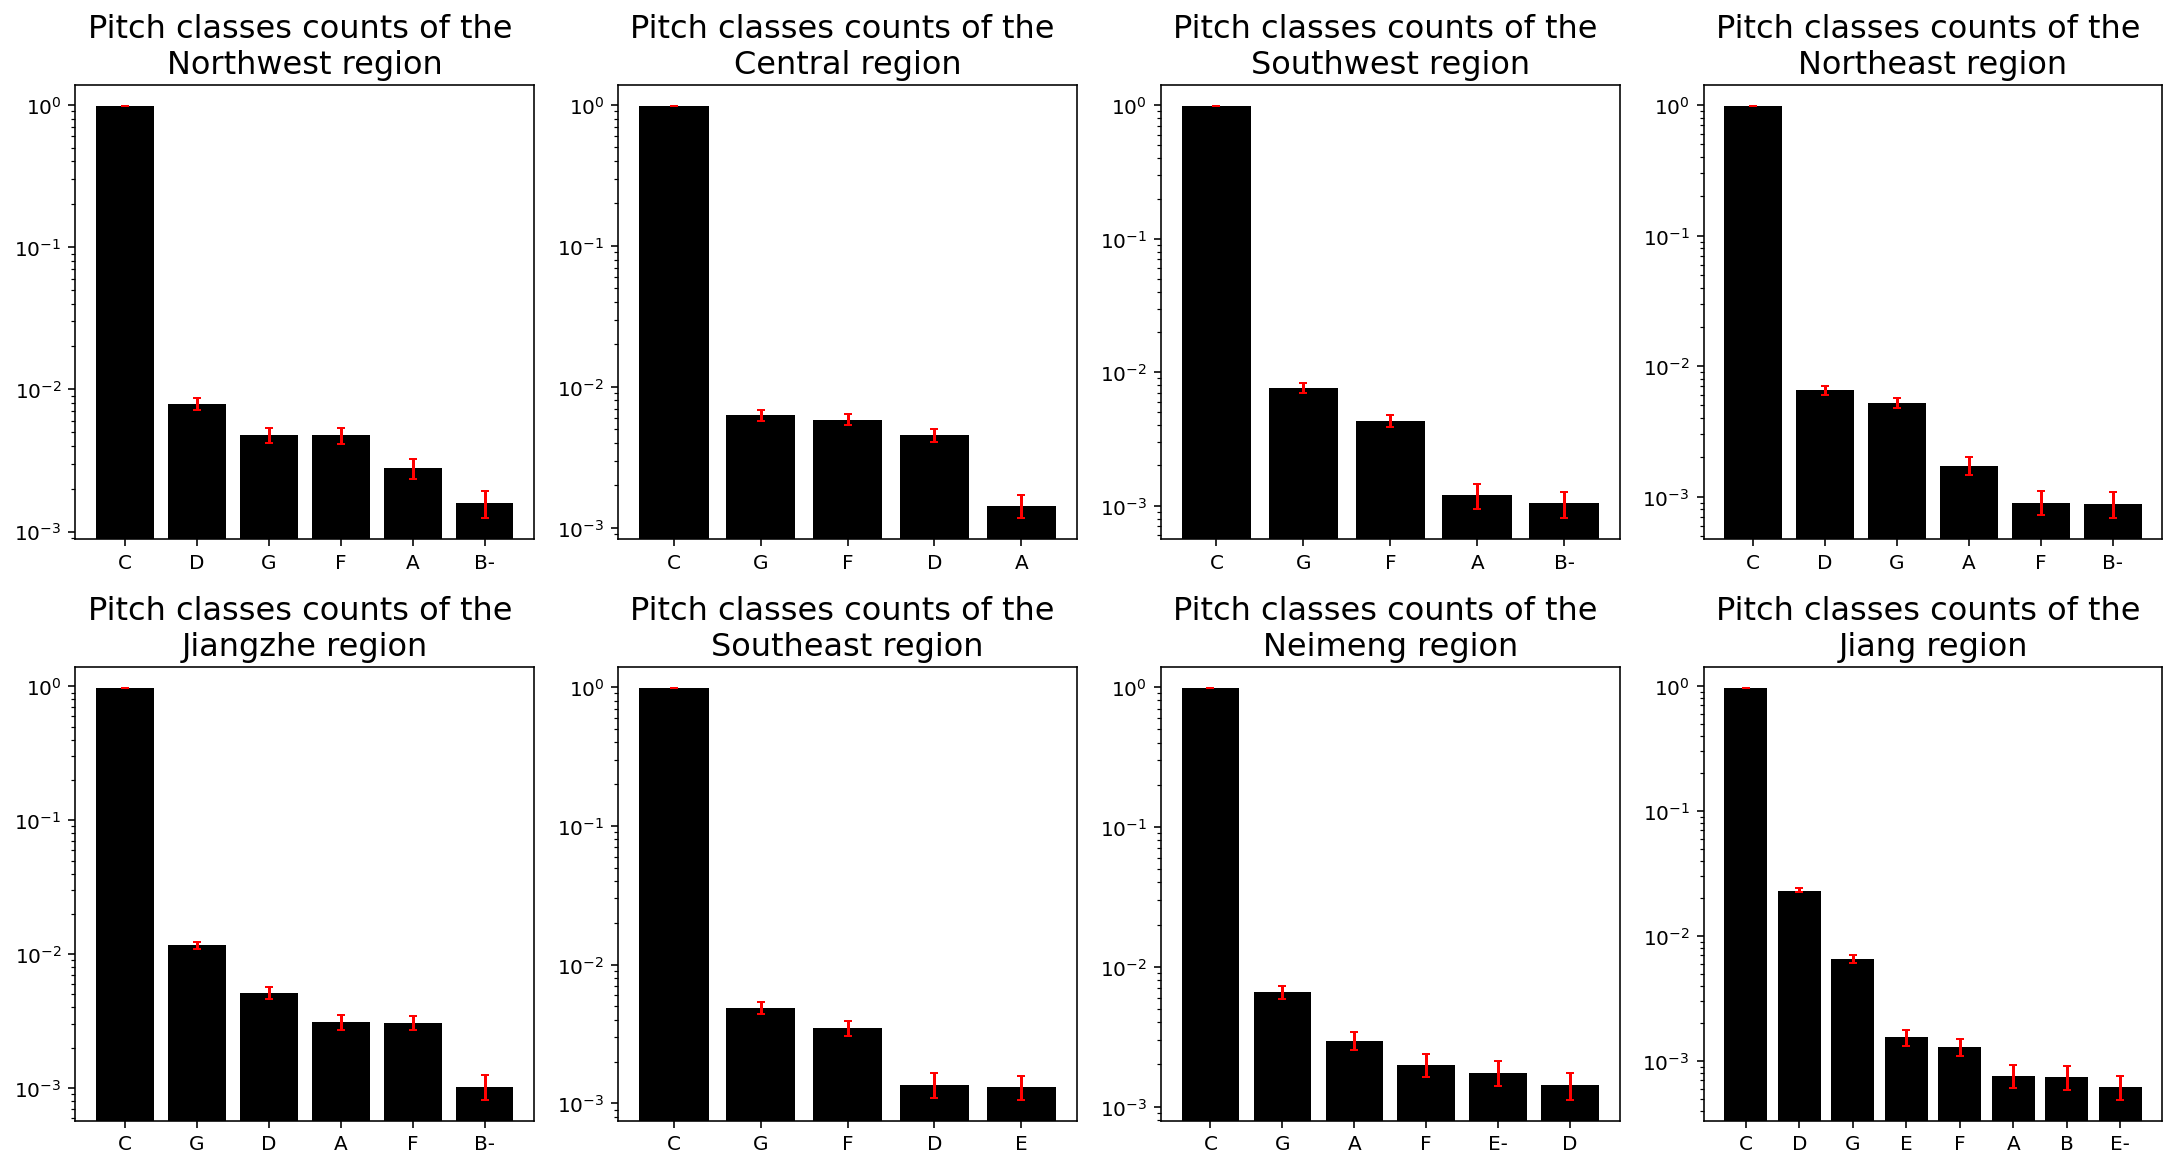

In [269]:
plot_region_stat_counts(region_random_walk, nrows=2, ncols=4, log_y=True, figsize=(15,8), title="Pitch classes counts of the \n{} region")

The bar plot above with a log scale on the y-axis provides us with the most commonly visited nodes in decreasing order of frequency. While we see that *C* occurs most frequently which is two orders greater than the next occurring note. This indicates that the stable note in pieces across all the regions is *C* i.e. the tonic similar to western music.

## Conclusion
At the end of this Milestone, we observe that no analysis provide sufficient proof that there is any significant difference in the modal organization in the CFS of the different regions. On the contrary, the results show deep cross-regional similarities. However, the interpretation of the plots was only shallow in this report, as they only convey the most striking observations. For the next Milestone, we will need to dive deeper into the analyses to extract all the similarities and differences. Moreover, it will also be interesting to put these results in comparison to the ones obtained by Huron in *Sweet Anticipation* on the corpus of Germanic Folk Songs. With the support of the results obtained in this milestone, we anticipate that the modal organization of the CFS is similar to the one observed by Huron.


## References
1. Huron, David. Sweet anticipation: Music and the psychology of expectation. MIT press, 2008. https://mitpress.mit.edu/books/sweet-anticipation
2. '中国民歌 百度百科'. Accessed 11 April 2021. https://baike.baidu.com/item/%E4%B8%AD%E5%9B%BD%E6%B0%91%E6%AD%8C.
3. Essen Associative Code (EsAC) and folksong Database. http://www.esac-data.org/